In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

In [4]:
from sklearn import linear_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
%pip install numpy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 31.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.13.4 requires numpy<1.23,>=1.21.0, but you have numpy 1.23.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## Load Data

In [5]:
def df_dict_from_pkls():
    
    df_dict = {}
    
    for root, dirs, files in os.walk("./data/pkl", topdown=False):
        for name in files:
            file_path = os.path.join(root, name)
            df = pd.read_pickle(file_path)
            df_dict[name[:-4]] = df
    
    return df_dict

df_dict = df_dict_from_pkls()

df_dict.keys()

dict_keys(['B10_0', 'B12_0', 'B13_0', 'B14_1', 'B15_1', 'B16_0', 'B17_0', 'B18_1', 'B19_1', 'B1_0', 'B20_0', 'B2_0', 'B4_0', 'B5_0', 'B6_0'])

In [6]:
df_dict['B19_1'].head()

,Id,Img Id,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,...,Filter5,Filter6,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity,Fiber Length,Fiber Width,Flow,Flow Class
0,497,93,75.271,111.108,77.917,103.662,99.352,68.668,223297.466,4449.863,...,Reject,Reject,1.330,0.752,21831.799,1.447,141.829,31.375,18.82,1
1,1148,157,81.792,109.617,77.498,115.331,101.638,74.907,286499.936,5254.206,...,Reject,Reject,1.488,0.672,25411.466,1.357,130.807,40.168,18.82,1
2,2574,372,77.578,85.572,77.028,80.767,78.027,77.238,244463.906,4726.801,...,Reject,Reject,1.049,0.954,19448.796,1.010,0.000,0.000,18.82,1
3,1981,258,77.654,81.371,76.001,81.525,79.228,76.196,245180.011,4736.027,...,Reject,Reject,1.073,0.932,19295.068,1.040,0.000,0.000,18.82,1
4,491,93,70.913,94.345,73.622,88.799,80.050,73.769,186717.428,3949.548,...,Reject,Reject,1.206,0.829,18711.459,1.085,111.162,35.530,18.82,1


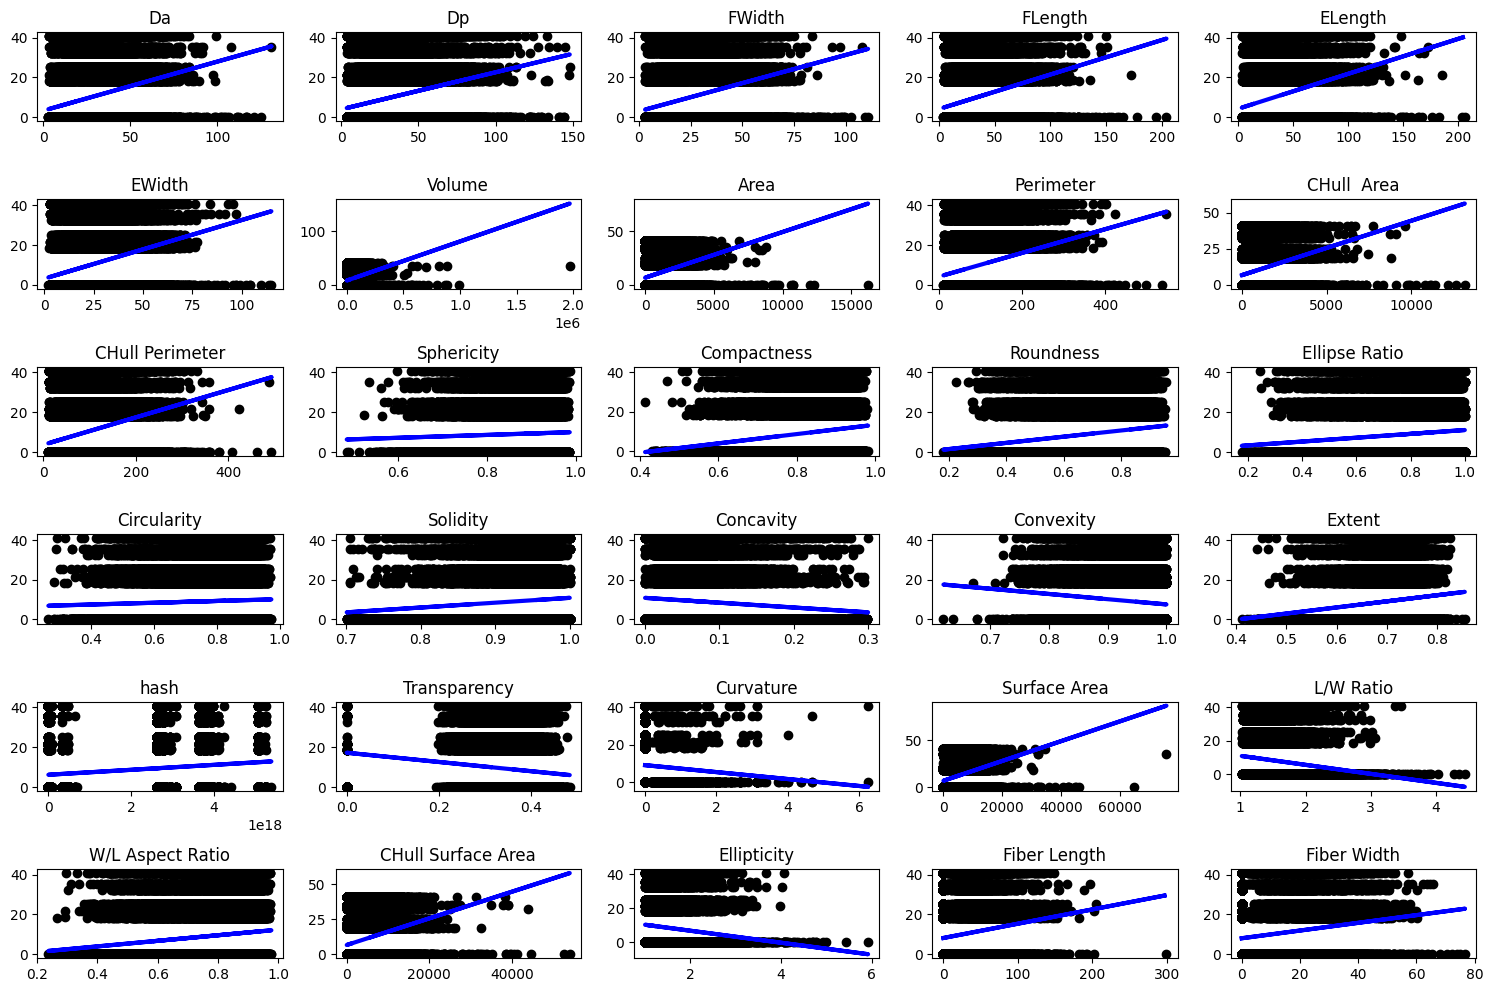

In [138]:
df = pd.concat(df_dict.values(), axis = 0)

df = df._get_numeric_data()

figure, axis = plt.subplots(6, 5, figsize=(15, 10))

for i,col in enumerate(df.columns[2:-2]):
    
    df_col = df[[col,'Flow']]
    
    train, test = train_test_split(df_col, test_size=0.2)
    
    x_train = train[col].values.reshape(-1,1)
    y_train = train['Flow'].values
    
    x_test = test[col].values.reshape(-1,1)
    y_test = test['Flow'].values
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train,y_train)
    #y_pred = regr.predict(x_test)
    
    ax = axis.flatten()[i]
    ax.scatter(x_test, y_test, color = 'black')
    ax.plot(x_test, regr.predict(x_test), color='blue', linewidth=3)
    ax.set_title(label = col)
    
figure.tight_layout(pad=1)
plt.show()

In [31]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [56]:
df = pd.concat(df_dict.values(), axis = 0)

df = df._get_numeric_data().reset_index(drop = True)
df_features = df.drop(['Id', 'Img Id', 'hash', 'Flow', 'Flow Class'],axis = 1)
df_features = variance_threshold_selector(df_features, 0.8)

print(df_features.columns)

df = pd.concat([df_features, df['Flow'], df['Flow Class']], axis = 1)

train, test = train_test_split(df, test_size=0.2)

train_x = train.iloc[:,:-2]
train_y = train.iloc[:,-2]
train_class = train.iloc[:,-1]

test_x = test.iloc[:,:-2]
test_y = test.iloc[:,-2]
test_class = test.iloc[:,-1]

regr = linear_model.LinearRegression()
regr.fit(train_x,train_y)

pred_y = regr.predict(test_x)

print('mean_squared_error : ', mean_squared_error(test_y, pred_y))
print('mean_absolute_error : ', mean_absolute_error(test_y, pred_y))

Index(['Da', 'Dp', 'FWidth', 'FLength', 'ELength', 'EWidth', 'Volume', 'Area',
       'Perimeter', 'CHull  Area', 'CHull Perimeter', 'Surface Area',
       'CHull Surface Area', 'Fiber Length', 'Fiber Width'],
      dtype='object')
mean_squared_error :  182.41838452287124
mean_absolute_error :  11.056486428893928


In [54]:
print('no-flow: mean_squared_error : ', mean_squared_error(test_y[test_class == 0], pred_y[test_class == 0]))
print('no-flow: mean_absolute_error : ', mean_absolute_error(test_y[test_class == 0], pred_y[test_class == 0]))

no-flow: mean_squared_error :  197.09707509909455
no-flow: mean_absolute_error :  11.385242999573478


In [55]:
print('flow: mean_squared_error : ', mean_squared_error(test_y[test_class == 1], pred_y[test_class == 1]))
print('flow: mean_absolute_error : ', mean_absolute_error(test_y[test_class == 1], pred_y[test_class == 1]))

flow: mean_squared_error :  124.34216626524332
flow: mean_absolute_error :  9.900631032583012


In [21]:
X2 = sm.add_constant(train_x)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Flow   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     439.3
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:57:45   Log-Likelihood:            -4.6451e+05
No. Observations:              115461   AIC:                         9.291e+05
Df Residuals:                  115431   BIC:                         9.294e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               6516.2910   6761